In [1]:
# 1) Design model (input size, output size, forward pass)
# 2) Construct loss and optimizer
# 3) Training loop
#    - forward pass: compute prediction and loss
#    - backward pass: gradients
#    - update weights


# SIFAR-10
# DataLoader, Transformation
# Multilayer Neural Net, activation function
# Loss and Optimizer
# Training Loop (batch training)
# Model evaluation
# GPU support

# ENV: Python 3.9.12

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as fnc
import torchvision # some builtin datasets
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader

import math
import numpy as np
import matplotlib.pyplot as plt

In [31]:
# Settings

# device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# hyper parameters
num_epoches = 20
batch_size = 10
learning_rate = 0.001

device: cuda


In [32]:
# CIFAR10
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])
train_data = torchvision.datasets.CIFAR10(
    root="./data", 
    train=True,
    transform=transform,
    download=True)

test_data = torchvision.datasets.CIFAR10(
    root="./data", 
    train=False,
    transform=transform)

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([10, 3, 32, 32]) torch.Size([10])
torch.Size([10, 3, 32, 32]) torch.Size([10])


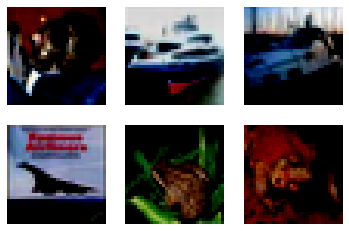

In [33]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_data, 
    batch_size=batch_size,
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    dataset=test_data, 
    batch_size=batch_size,
    shuffle=False)

examples = iter(train_loader)
samples, labels = examples.next()
print(samples.shape, labels.shape)

examples = iter(test_loader)
samples, labels = examples.next()
print(samples.shape, labels.shape)

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(samples[i].permute(1, 2, 0)) #change from C, H, W to H, W, C.
    plt.axis("off")
plt.show()

In [39]:
images, labels = examples.next()
conv1 = nn.Conv2d(3, 6, 5) # C, output C, filter 5 x 5, stride = 1 by default
pool1 = nn.MaxPool2d(2, 2) # kernel_size, stride
conv2 = nn.Conv2d(6, 16, 5)
pool2 = nn.MaxPool2d(2, 2) # kernel_size, stride

print(images.shape)
x = conv1(images)
print(x.shape)
x = pool1(x)
print("after pool1:", x.shape)

x = conv2(x)
print("after conv2:", x.shape)
x = pool2(x)
print("after pool2:", x.shape)


torch.Size([10, 3, 32, 32])
torch.Size([10, 6, 28, 28])
after pool1: torch.Size([10, 6, 14, 14])
after conv2: torch.Size([10, 16, 10, 10])
after pool2: torch.Size([10, 16, 5, 5])


In [34]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
'dog', 'frog', 'horse', 'ship', 'truck')

In [41]:
# Model
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # C, output C, filter 5 x 5, stride = 1 by default
        self.pool1 = nn.MaxPool2d(2, 2) # kernel_size, stride
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2) # kernel_size, stride
        
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, 10)

    def forward(self, x):
        x = self.pool1(fnc.relu(self.conv1(x)))
        x = self.pool2(fnc.relu(self.conv2(x)))

        x = x.view(-1, 16*5*5)
        x = fnc.relu(self.fc1(x))
        x = fnc.relu(self.fc2(x))
        x = self.fc3(x)

        return x

model = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [42]:
# Training loop
num_total_steps = len(train_loader)

for epoch in range(num_epoches):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # forward
        y_pred = model(images)
        loss = criterion(y_pred, labels)
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 1000 == 0:
            print(f'epoch {epoch+1} / {num_epoches}, step {i+1} / {num_total_steps}, loss = {loss: 0.4f}')
print('finish training')


epoch 1 / 20, step 1000 / 5000, loss =  2.3080
epoch 1 / 20, step 2000 / 5000, loss =  2.3027
epoch 1 / 20, step 3000 / 5000, loss =  2.2823
epoch 1 / 20, step 4000 / 5000, loss =  2.3052
epoch 1 / 20, step 5000 / 5000, loss =  2.2792
epoch 2 / 20, step 1000 / 5000, loss =  2.3168
epoch 2 / 20, step 2000 / 5000, loss =  2.2859
epoch 2 / 20, step 3000 / 5000, loss =  2.2915
epoch 2 / 20, step 4000 / 5000, loss =  2.2962
epoch 2 / 20, step 5000 / 5000, loss =  2.2316
epoch 3 / 20, step 1000 / 5000, loss =  2.1812
epoch 3 / 20, step 2000 / 5000, loss =  2.2331
epoch 3 / 20, step 3000 / 5000, loss =  1.9081
epoch 3 / 20, step 4000 / 5000, loss =  1.9105
epoch 3 / 20, step 5000 / 5000, loss =  2.3097
epoch 4 / 20, step 1000 / 5000, loss =  1.8698
epoch 4 / 20, step 2000 / 5000, loss =  1.9246
epoch 4 / 20, step 3000 / 5000, loss =  1.8202
epoch 4 / 20, step 4000 / 5000, loss =  1.8811
epoch 4 / 20, step 5000 / 5000, loss =  1.9587
epoch 5 / 20, step 1000 / 5000, loss =  2.0713
epoch 5 / 20,

In [46]:
# Evaluation
with torch.no_grad():
    # overall acc
    n_correct = 0
    n_samples = 0

    # class-level acc
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        y_eva = model(images)
        _, y_eva_cls = torch.max(y_eva, 1)
        n_samples += labels.shape[0]
        n_correct += (y_eva_cls == labels).sum().item()

        for idx in range(batch_size):
            label = labels[idx]
            pred = y_eva_cls[idx]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100*n_correct/n_samples
    print(f'acc = {acc:.2f}%')
    for i in range(10):
        acc_i = 100*n_class_correct[i] / n_class_samples[i]
        print(f'{classes[i]}:{acc_i:.0f}%')

acc = 56.86%
plane:60%
car:70%
bird:43%
cat:30%
deer:49%
dog:52%
frog:54%
horse:70%
ship:74%
truck:65%
